In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss, log_loss,
    confusion_matrix, classification_report, roc_curve,
    f1_score, precision_score, recall_score
)

import lightgbm as lgb
import xgboost as xgb

import requests
import json
import time
import pickle
import os
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import defaultdict

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

### 1. setup & configuration 

In [2]:
LICHESS_TOKEN = os.environ.get('LICHESS_TOKEN', '')  

PLAYER_LIST_FILE = r"C:\Users\vitus\Desktop\master\master_project\chess-app\player_list_by_rating.json" 
GAME_TYPE = "blitz"
GAMES_PER_PLAYER = 200

FORM_WINDOWS = [5, 10, 20]
MIN_GAMES_FOR_STATS = 10

TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

CHART_TEMPLATE = "plotly_white"
COLOR_WIN = "#2ecc71"
COLOR_LOSS = "#e74c3c"
COLOR_DRAW = "#f39c12"
COLOR_PRIMARY = "#3498db"

MODEL_OUTPUT_PATH = "win_probability_model.pkl"
DATA_OUTPUT_PATH = "training_data.parquet"

print("Configuration loaded")
print(f"  Game Type: {GAME_TYPE}")
print(f"  Games per player: {GAMES_PER_PLAYER}")
print(f"  Player list file: {PLAYER_LIST_FILE}")

Configuration loaded
  Game Type: blitz
  Games per player: 200
  Player list file: C:\Users\vitus\Desktop\master\master_project\chess-app\player_list_by_rating.json


### 2. load player list

In [3]:
with open(PLAYER_LIST_FILE, 'r') as f:
    player_list_by_rating = json.load(f)

print("Player list loaded:")
print("\nRating Range | Players")
print("-" * 30)
for range_key, players in player_list_by_rating.items():
    print(f"{range_key:12} | {len(players):7}")

all_players = []
for players in player_list_by_rating.values():
    all_players.extend(players)

print(f"\nTotal players: {len(all_players)}")

Player list loaded:

Rating Range | Players
------------------------------
1000-1200    |     200
1200-1400    |     200
1400-1600    |     200
1600-1800    |     200
1800-2000    |     200
2000-2200    |     200
2200-2400    |     200
2400-2600    |     200
2600-2800    |      59

Total players: 1659


In [4]:
# Complete 2600-2800 range if needed 
def fetch_top_players_to_complete(rating_range, current_players, target_count=200, perf_type="blitz"):
    """
    Fetch top players from leaderboard to complete a rating range.
    """
    if len(current_players) >= target_count:
        return current_players
    
    needed = target_count - len(current_players)
    print(f"\nCompleting {rating_range}: need {needed} more players")
    
    url = f"https://lichess.org/api/player/top/200/{perf_type}"
    headers = {"Accept": "application/json"}
    if LICHESS_TOKEN:
        headers["Authorization"] = f"Bearer {LICHESS_TOKEN}"
    
    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        # Filter by rating range
        min_r, max_r = map(int, rating_range.split('-'))
        additional = []
        
        for player in data.get('users', []):
            username = player['username']
            rating = player['perfs'].get(perf_type, {}).get('rating', 0)
            
            if min_r <= rating < max_r and username not in current_players:
                additional.append(username)
                
                if len(additional) >= needed:
                    break
        
        print(f"  Added {len(additional)} players from leaderboard")
        return current_players + additional
        
    except Exception as e:
        print(f"  Error fetching top players: {e}")
        return current_players


for range_key in ['2600-2800', '2400-2600']:
    if range_key in player_list_by_rating:
        original_count = len(player_list_by_rating[range_key])
        if original_count < 200:
            player_list_by_rating[range_key] = fetch_top_players_to_complete(
                range_key, 
                player_list_by_rating[range_key],
                target_count=200,
                perf_type=GAME_TYPE
            )
            new_count = len(player_list_by_rating[range_key])
            print(f"  {range_key}: {original_count} -> {new_count}")
            time.sleep(1)

all_players = []
for players in player_list_by_rating.values():
    all_players.extend(players)

print(f"\nFinal total players: {len(all_players)}")


Completing 2600-2800: need 141 more players
  Added 30 players from leaderboard
  2600-2800: 59 -> 89

Final total players: 1689


### 3. data collection 

In [5]:
def get_headers():
    """Get API headers with optional authentication."""
    headers = {"Accept": "application/x-ndjson"}
    if LICHESS_TOKEN:
        headers["Authorization"] = f"Bearer {LICHESS_TOKEN}"
    return headers


def fetch_user_games(username, max_games=200, perf_type="blitz"):
    """
    Fetch games for a specific user from Lichess API.
    """
    url = f"https://lichess.org/api/games/user/{username}"
    headers = get_headers()
    params = {
        "max": max_games,
        "rated": "true",
        "perfType": perf_type,
        "clocks": "true",
        "opening": "true",
        "pgnInJson": "true"
    }
    
    games = []
    
    try:
        response = requests.get(url, headers=headers, params=params, stream=True, timeout=60)
        response.raise_for_status()
        
        for line in response.iter_lines():
            if line:
                game = json.loads(line.decode('utf-8'))
                games.append(game)
                
    except requests.exceptions.RequestException as e:
        print(f"Error fetching games for {username}: {e}")
    
    return games


def collect_all_games(players, games_per_player=200, perf_type="blitz"):
    """
    Collect games for all players.
    """
    all_games = {}
    failed_players = []
    
    print(f"\nFetching games for {len(players)} players...")
    print(f"Target: {games_per_player} games per player")
    print(f"Estimated time: {len(players) * 1.5 / 60:.1f} minutes\n")
    
    for i, player in enumerate(tqdm(players, desc="Fetching games")):
        try:
            games = fetch_user_games(player, max_games=games_per_player, perf_type=perf_type)
            
            if len(games) >= MIN_GAMES_FOR_STATS:
                all_games[player] = games
            else:
                failed_players.append((player, f"Only {len(games)} games"))
                
        except Exception as e:
            failed_players.append((player, str(e)))
        
        # Rate limiting
        sleep_time = 0.5 if LICHESS_TOKEN else 1.5
        time.sleep(sleep_time)
        
        # Progress update
        if (i + 1) % 50 == 0:
            total_games = sum(len(g) for g in all_games.values())
            print(f"\n   Progress: {i+1}/{len(players)} players, {total_games:,} games collected")
    
    # Summary
    total_games = sum(len(g) for g in all_games.values())
    print(f"\nCollection complete!")
    print(f"  Players with data: {len(all_games)}")
    print(f"  Total games: {total_games:,}")
    print(f"  Failed players: {len(failed_players)}")
    
    return all_games

In [6]:
print("data collection")

all_games_dict = collect_all_games(
    all_players, 
    games_per_player=GAMES_PER_PLAYER, 
    perf_type=GAME_TYPE
)

data collection

Fetching games for 1689 players...
Target: 200 games per player
Estimated time: 42.2 minutes



Fetching games:   3%|▎         | 50/1689 [06:53<3:43:17,  8.17s/it]


   Progress: 50/1689 players, 10,458 games collected


Fetching games:   6%|▌         | 100/1689 [13:43<3:43:41,  8.45s/it]


   Progress: 100/1689 players, 20,762 games collected


Fetching games:   6%|▌         | 105/1689 [14:26<3:43:41,  8.47s/it]

Error fetching games for pierre_dole_chess: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/pierre_dole_chess?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:   7%|▋         | 119/1689 [16:15<3:34:10,  8.19s/it]

Error fetching games for MidlifeBoardom: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/MidlifeBoardom?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:   8%|▊         | 138/1689 [18:39<3:34:49,  8.31s/it]

Error fetching games for BRDuck: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/BRDuck?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:   9%|▉         | 150/1689 [20:03<3:30:08,  8.19s/it]


   Progress: 150/1689 players, 30,177 games collected


Fetching games:  12%|█▏        | 200/1689 [26:39<3:27:16,  8.35s/it]


   Progress: 200/1689 players, 40,118 games collected


Fetching games:  13%|█▎        | 222/1689 [29:42<3:25:56,  8.42s/it]

Error fetching games for BloadBanger: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/BloadBanger?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  14%|█▍        | 238/1689 [31:53<3:32:01,  8.77s/it]

Error fetching games for SolomonOsa: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/SolomonOsa?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  15%|█▍        | 250/1689 [33:26<3:16:36,  8.20s/it]


   Progress: 250/1689 players, 50,198 games collected


Fetching games:  18%|█▊        | 300/1689 [40:47<3:17:54,  8.55s/it]


   Progress: 300/1689 players, 60,698 games collected


Fetching games:  19%|█▊        | 314/1689 [42:44<2:47:51,  7.32s/it]

Error fetching games for AntUwU: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/AntUwU?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  20%|█▉        | 336/1689 [45:41<3:10:28,  8.45s/it]

Error fetching games for VitaliySosnin: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/VitaliySosnin?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  21%|██        | 350/1689 [47:33<3:10:17,  8.53s/it]


   Progress: 350/1689 players, 70,591 games collected


Fetching games:  24%|██▎       | 400/1689 [54:40<3:11:46,  8.93s/it]


   Progress: 400/1689 players, 80,951 games collected


Fetching games:  25%|██▍       | 416/1689 [57:00<3:01:07,  8.54s/it]

Error fetching games for PoachedHam: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/PoachedHam?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  26%|██▌       | 435/1689 [59:34<3:03:54,  8.80s/it]

Error fetching games for mztejero: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/mztejero?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  27%|██▋       | 450/1689 [1:01:41<3:14:59,  9.44s/it]


   Progress: 450/1689 players, 91,031 games collected


Fetching games:  28%|██▊       | 468/1689 [1:04:14<2:54:08,  8.56s/it]

Error fetching games for jonadav50: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/jonadav50?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  30%|██▉       | 500/1689 [1:08:34<2:52:00,  8.68s/it]


   Progress: 500/1689 players, 101,167 games collected


Fetching games:  33%|███▎      | 550/1689 [1:15:48<2:52:41,  9.10s/it]


   Progress: 550/1689 players, 111,667 games collected


Fetching games:  33%|███▎      | 560/1689 [1:17:16<2:51:01,  9.09s/it]

Error fetching games for Sack-The-Rook123: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Sack-The-Rook123?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  36%|███▌      | 600/1689 [1:23:03<2:44:27,  9.06s/it]


   Progress: 600/1689 players, 121,957 games collected


Fetching games:  36%|███▌      | 601/1689 [1:23:11<2:40:10,  8.83s/it]

Error fetching games for vidyoe2: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/vidyoe2?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  37%|███▋      | 630/1689 [1:27:15<2:35:30,  8.81s/it]

Error fetching games for zanderchess2: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/zanderchess2?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  38%|███▊      | 644/1689 [1:29:08<2:28:11,  8.51s/it]

Error fetching games for DADOODS_A: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/DADOODS_A?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  38%|███▊      | 650/1689 [1:29:55<2:33:22,  8.86s/it]


   Progress: 650/1689 players, 131,827 games collected


Fetching games:  41%|████▏     | 698/1689 [1:37:00<2:30:24,  9.11s/it]

Error fetching games for caovinh123: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/caovinh123?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  41%|████▏     | 700/1689 [1:37:10<2:00:44,  7.33s/it]


   Progress: 700/1689 players, 142,117 games collected


Fetching games:  42%|████▏     | 717/1689 [1:39:44<2:21:21,  8.73s/it]

Error fetching games for Ame-Yume: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Ame-Yume?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  44%|████▍     | 750/1689 [1:44:29<2:21:51,  9.06s/it]


   Progress: 750/1689 players, 152,407 games collected


Fetching games:  47%|████▋     | 800/1689 [1:51:37<2:09:06,  8.71s/it]


   Progress: 800/1689 players, 162,848 games collected


Fetching games:  50%|█████     | 850/1689 [1:58:57<2:02:29,  8.76s/it]


   Progress: 850/1689 players, 173,348 games collected


Fetching games:  53%|█████▎    | 899/1689 [2:06:14<1:57:52,  8.95s/it]

Error fetching games for drgrekostein24: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/drgrekostein24?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  53%|█████▎    | 900/1689 [2:06:15<1:26:08,  6.55s/it]


   Progress: 900/1689 players, 183,638 games collected


Fetching games:  56%|█████▌    | 950/1689 [2:13:35<1:41:24,  8.23s/it]


   Progress: 950/1689 players, 194,138 games collected


Fetching games:  58%|█████▊    | 982/1689 [2:18:21<1:49:43,  9.31s/it]

Error fetching games for tuanna222: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/tuanna222?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  59%|█████▊    | 991/1689 [2:19:27<1:34:00,  8.08s/it]

Error fetching games for Simply_MJ: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Simply_MJ?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  59%|█████▉    | 1000/1689 [2:20:37<1:35:12,  8.29s/it]


   Progress: 1000/1689 players, 204,183 games collected
Error fetching games for Insinual: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Insinual?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  62%|██████▏   | 1050/1689 [2:27:48<1:33:05,  8.74s/it]


   Progress: 1050/1689 players, 214,425 games collected


Fetching games:  65%|██████▌   | 1100/1689 [2:35:13<1:27:54,  8.96s/it]


   Progress: 1100/1689 players, 224,925 games collected


Fetching games:  67%|██████▋   | 1128/1689 [2:39:25<1:22:59,  8.88s/it]

Error fetching games for KingMelchior: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/KingMelchior?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  67%|██████▋   | 1132/1689 [2:39:53<1:15:34,  8.14s/it]

Error fetching games for CosmicCastle: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/CosmicCastle?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  68%|██████▊   | 1150/1689 [2:42:21<1:18:07,  8.70s/it]


   Progress: 1150/1689 players, 235,005 games collected


Fetching games:  71%|███████   | 1200/1689 [2:49:41<1:13:09,  8.98s/it]


   Progress: 1200/1689 players, 245,381 games collected


Fetching games:  73%|███████▎  | 1225/1689 [2:53:26<1:11:20,  9.23s/it]

Error fetching games for Dennisherov_Norbe: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Dennisherov_Norbe?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  73%|███████▎  | 1233/1689 [2:54:28<1:05:18,  8.59s/it]

Error fetching games for purifieddrinkingh2o: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/purifieddrinkingh2o?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  74%|███████▍  | 1250/1689 [2:56:48<1:02:31,  8.55s/it]


   Progress: 1250/1689 players, 255,461 games collected


Fetching games:  77%|███████▋  | 1300/1689 [3:04:01<56:23,  8.70s/it]  


   Progress: 1300/1689 players, 265,961 games collected


Fetching games:  80%|███████▉  | 1350/1689 [3:11:11<49:52,  8.83s/it]


   Progress: 1350/1689 players, 276,430 games collected


Fetching games:  80%|████████  | 1356/1689 [3:12:04<49:03,  8.84s/it]

Error fetching games for enmebaragasi: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/enmebaragasi?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  83%|████████▎ | 1400/1689 [3:18:13<43:56,  9.12s/it]


   Progress: 1400/1689 players, 286,582 games collected


Fetching games:  84%|████████▍ | 1426/1689 [3:21:59<38:17,  8.74s/it]

Error fetching games for chi_ram: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/chi_ram?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  86%|████████▌ | 1450/1689 [3:25:21<34:08,  8.57s/it]


   Progress: 1450/1689 players, 296,872 games collected


Fetching games:  88%|████████▊ | 1479/1689 [3:29:30<29:55,  8.55s/it]

Error fetching games for duongnhi79aa: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/duongnhi79aa?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  88%|████████▊ | 1489/1689 [3:30:47<27:41,  8.31s/it]

Error fetching games for Ferrari011: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Ferrari011?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  89%|████████▉ | 1500/1689 [3:32:13<25:56,  8.24s/it]


   Progress: 1500/1689 players, 306,952 games collected


Fetching games:  92%|█████████▏| 1550/1689 [3:39:20<19:33,  8.44s/it]


   Progress: 1550/1689 players, 317,310 games collected


Fetching games:  95%|█████████▍| 1600/1689 [3:46:36<13:05,  8.83s/it]


   Progress: 1600/1689 players, 327,810 games collected


Fetching games:  96%|█████████▌| 1619/1689 [3:49:18<09:44,  8.35s/it]

Error fetching games for withyourmoney: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/withyourmoney?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  97%|█████████▋| 1634/1689 [3:51:17<07:47,  8.50s/it]

Error fetching games for Ignathor: 404 Client Error: Not Found for url: https://lichess.org/api/games/user/Ignathor?max=200&rated=true&perfType=blitz&clocks=true&opening=true&pgnInJson=true


Fetching games:  98%|█████████▊| 1650/1689 [3:53:27<05:30,  8.47s/it]


   Progress: 1650/1689 players, 337,890 games collected


Fetching games: 100%|██████████| 1689/1689 [3:58:44<00:00,  8.48s/it]


Collection complete!
  Players with data: 1659
  Total games: 345,906
  Failed players: 30


In [8]:
# Save raw data
raw_data_path = "raw_games_data.json"

with open(raw_data_path, 'w') as f:
    json.dump(all_games_dict, f)

print(f"Raw data saved to {raw_data_path}")
print(f"File size: {os.path.getsize(raw_data_path) / (1024*1024):.2f} MB")

Raw data saved to raw_games_data.json
File size: 1279.57 MB


In [3]:
raw_data_path = "raw_games_data.json"

with open(raw_data_path, 'r') as f:
    all_games_dict = json.load(f)

print(f"Loaded {len(all_games_dict)} players")
print(f"Total games: {sum(len(g) for g in all_games_dict.values()):,}")

Loaded 1659 players
Total games: 345,906


### 4. Data Processing

In [4]:
def process_single_game(game, player_username):
    """
    Process a single game and extract relevant features.
    """
    try:
        players = game.get('players', {})
        white_info = players.get('white', {})
        black_info = players.get('black', {})
        
        white_user = white_info.get('user', {}).get('name', '').lower()
        black_user = black_info.get('user', {}).get('name', '').lower()
        
        # Determine player color
        is_white = white_user == player_username.lower()
        player_color = 'white' if is_white else 'black'
        opponent_color = 'black' if is_white else 'white'
        
        player_info = white_info if is_white else black_info
        opponent_info = black_info if is_white else white_info
        
        # Extract ratings
        player_rating = player_info.get('rating')
        opponent_rating = opponent_info.get('rating')
        
        if not player_rating or not opponent_rating:
            return None
        
        # Determine outcome
        winner = game.get('winner')
        if winner == player_color:
            outcome = 'win'
            outcome_numeric = 1.0
        elif winner is None:
            outcome = 'draw'
            outcome_numeric = 0.5
        else:
            outcome = 'loss'
            outcome_numeric = 0.0
        
        # Game timestamp
        created_at = game.get('createdAt', 0)
        game_date = pd.to_datetime(created_at, unit='ms') if created_at else None
        
        # Opening info
        opening = game.get('opening', {})
        opening_eco = opening.get('eco', 'Unknown')
        eco_category = opening_eco[0] if opening_eco and opening_eco != 'Unknown' else 'X'
        
        # Clock/time analysis
        clocks = game.get('clocks', [])
        time_trouble = 0
        final_clock = None
        avg_time_per_move = None
        
        if clocks and len(clocks) > 0:
            player_clocks = []
            for i, clock in enumerate(clocks):
                if (i % 2 == 0 and is_white) or (i % 2 == 1 and not is_white):
                    player_clocks.append(clock / 100)
            
            if player_clocks:
                final_clock = player_clocks[-1]
                min_clock = min(player_clocks)
                time_trouble = 1 if min_clock < 30 else 0
                
                if len(player_clocks) > 1:
                    time_spent = [player_clocks[i-1] - player_clocks[i] 
                                  for i in range(1, len(player_clocks))
                                  if player_clocks[i-1] - player_clocks[i] > 0]
                    if time_spent:
                        avg_time_per_move = np.mean(time_spent)
        
        # Game length
        moves_str = game.get('moves', '')
        num_moves = len(moves_str.split()) // 2 if moves_str else 0
        
        return {
            'game_id': game.get('id'),
            'player_username': player_username,
            'opponent_username': opponent_info.get('user', {}).get('name', 'Anonymous'),
            'date': game_date,
            'player_color': player_color,
            'player_rating': player_rating,
            'opponent_rating': opponent_rating,
            'rating_gap': opponent_rating - player_rating,
            'outcome': outcome,
            'outcome_numeric': outcome_numeric,
            'outcome_binary': 1 if outcome == 'win' else 0,
            'opening_eco': opening_eco,
            'eco_category': eco_category,
            'num_moves': num_moves,
            'time_trouble': time_trouble,
            'final_clock': final_clock,
            'avg_time_per_move': avg_time_per_move,
            'hour_of_day': game_date.hour if game_date else None,
        }
        
    except Exception:
        return None


def process_all_games(all_games_dict):
    """
    Process all games from all players into a single DataFrame.
    """
    all_processed = []
    
    print("\nProcessing games...")
    
    for username, games in tqdm(all_games_dict.items(), desc="Processing players"):
        for game in games:
            processed = process_single_game(game, username)
            if processed:
                all_processed.append(processed)
    
    df = pd.DataFrame(all_processed)
    df = df.sort_values(['player_username', 'date']).reset_index(drop=True)
    
    print(f"\nProcessed {len(df):,} games from {df['player_username'].nunique()} players")
    
    return df

In [5]:
df_games = process_all_games(all_games_dict)

print("\nSample of processed data:")
df_games.head()


Processing games...


Processing players: 100%|██████████| 1659/1659 [00:28<00:00, 57.38it/s]



Processed 345,906 games from 1659 players

Sample of processed data:


game_id player_username opponent_username                    date  \
0  itow1QYa         A1MAZOV        NINO742535 2025-12-12 13:21:10.450   
1  mQZ5ruUQ         A1MAZOV          Calajaro 2025-12-12 13:26:07.161   
2  4uZVsaj6         A1MAZOV        bIunderbus 2025-12-12 13:31:45.302   
3  PNlrMdOe         A1MAZOV       RockClimber 2025-12-12 13:33:27.612   
4  er6OGu6j         A1MAZOV           NadG_78 2025-12-12 13:37:12.352   

  player_color  player_rating  opponent_rating  rating_gap outcome  \
0        black           1154             1226          72    loss   
1        black           1150             1115         -35     win   
2        white           1155             1210          55     win   
3        white           1162             1062        -100    loss   
4        white           1154             1089         -65    loss   

   outcome_numeric  outcome_binary opening_eco eco_category  num_moves  \
0           0.0000               0         A06            A         32   
1           1.0000               1         B01            B         54   
2           1.0000               1         A40            A         14   
3           0.0000               0         D00            D         24   
4           0.0000               0         A40            A         38   

   time_trouble  final_clock  avg_time_per_move  hour_of_day  
0             0      50.1600             4.1894           13  
1             0      31.6700             2.7992           13  
2             0     126.3600             3.8336           13  
3             0      66.2400             4.9474           13  
4             1      18.7300             4.2447           13

In [11]:
df_games["time_trouble"].value_counts()

time_trouble
0    231054
1    114852
Name: count, dtype: int64

In [6]:
# Data quality check
print(f"Total games: {len(df_games):,}")
print(f"Unique players: {df_games['player_username'].nunique()}")
print(f"Date range: {df_games['date'].min()} to {df_games['date'].max()}")
print(f"\nOutcome distribution:")
print(df_games['outcome'].value_counts())
print(f"\nMissing values:")
print(df_games.isnull().sum()[df_games.isnull().sum() > 0])

Total games: 345,906
Unique players: 1659
Date range: 2015-12-07 03:11:59.275000 to 2025-12-17 00:57:07.387000

Outcome distribution:
outcome
win     169381
loss    158720
draw     17805
Name: count, dtype: int64

Missing values:
final_clock           437
avg_time_per_move    2020
dtype: int64


### 5. Feature Engineering

In [12]:
def calculate_elo_expected(rating_diff):
    """Calculate expected score based on ELO rating difference."""
    return 1 / (1 + 10 ** (rating_diff / 400))


def calculate_player_state(player_df):
    """
    Calculate current state features for a player based on their game history.
    Features calculated using only PAST games.
    """
    df = player_df.copy()
    
    # Form features (rolling win rates)
    for window in FORM_WINDOWS:
        df[f'form_{window}'] = (
            df['outcome_numeric']
            .rolling(window=window, min_periods=1)
            .mean()
            .shift(1)
            .fillna(0.5)
        )
    
    # Streak feature
    streak = 0
    streaks = []
    for outcome in df['outcome_numeric']:
        streaks.append(streak)
        if outcome == 1:
            streak = streak + 1 if streak > 0 else 1
        elif outcome == 0:
            streak = streak - 1 if streak < 0 else -1
        else:
            streak = 0
    df['streak'] = streaks
    
    # Time management features
    df['time_trouble_rate'] = (
        df['time_trouble']
        .expanding()
        .mean()
        .shift(1)
        .fillna(0)
    )
    
    df['avg_time_per_move_rolling'] = (
        df['avg_time_per_move']
        .rolling(window=20, min_periods=1)
        .mean()
        .shift(1)
        .fillna(df['avg_time_per_move'].mean())
    )
    
    # Color performance
    df['white_wr'] = (
        df[df['player_color'] == 'white']['outcome_numeric']
        .expanding()
        .mean()
        .reindex(df.index)
        .ffill()
        .shift(1)
        .fillna(0.5)
    )
    
    df['black_wr'] = (
        df[df['player_color'] == 'black']['outcome_numeric']
        .expanding()
        .mean()
        .reindex(df.index)
        .ffill()
        .shift(1)
        .fillna(0.5)
    )
    
    # Game activity
    df['games_played'] = range(len(df))
    
    if df['date'].notna().all():
        df = df.set_index('date')
        df['games_last_7d'] = df['game_id'].rolling('7D').count().shift(1).fillna(0)
        df = df.reset_index()
    else:
        df['games_last_7d'] = 0
    
    # Rating trend
    df['rating_trend'] = (
        df['player_rating']
        .diff(periods=20)
        .shift(1)
        .fillna(0)
    )
    
    # Average game length
    df['avg_game_length'] = (
        df['num_moves']
        .rolling(window=20, min_periods=1)
        .mean()
        .shift(1)
        .fillna(30)
    )
    
    # Opening performance by ECO category
    for eco_cat in ['A', 'B', 'C', 'D', 'E']:
        eco_games = df[df['eco_category'] == eco_cat]['outcome_numeric']
        df[f'eco_{eco_cat}_wr'] = (
            eco_games
            .expanding()
            .mean()
            .reindex(df.index)
            .ffill()
            .shift(1)
            .fillna(0.5)
        )
    
    # ELO expected & residual
    df['elo_expected'] = df['rating_gap'].apply(calculate_elo_expected)
    df['residual'] = df['outcome_numeric'] - df['elo_expected']
    
    df['residual_ma10'] = (
        df['residual']
        .rolling(window=10, min_periods=1)
        .mean()
        .shift(1)
        .fillna(0)
    )
    
    return df


def engineer_features(df_games):
    """
    Apply feature engineering to all games.
    """
    print("\nEngineering features...")
    
    processed_dfs = []
    
    for username, player_df in tqdm(df_games.groupby('player_username'), desc="Processing players"):
        player_df = player_df.sort_values('date').reset_index(drop=True)
        processed = calculate_player_state(player_df)
        processed_dfs.append(processed)
    
    df_features = pd.concat(processed_dfs, ignore_index=True)
    
    # Remove first few games per player
    df_features = df_features[df_features['games_played'] >= MIN_GAMES_FOR_STATS]
    
    print(f"\nFeature engineering complete!")
    print(f"Games with features: {len(df_features):,}")
    
    return df_features

In [13]:
df_features = engineer_features(df_games)

print("\nNew features added:")
new_cols = [col for col in df_features.columns if col not in df_games.columns]
print(new_cols)


Engineering features...


Processing players: 100%|██████████| 1659/1659 [00:15<00:00, 105.96it/s]



Feature engineering complete!
Games with features: 329,316

New features added:
['form_5', 'form_10', 'form_20', 'streak', 'time_trouble_rate', 'avg_time_per_move_rolling', 'white_wr', 'black_wr', 'games_played', 'games_last_7d', 'rating_trend', 'avg_game_length', 'eco_A_wr', 'eco_B_wr', 'eco_C_wr', 'eco_D_wr', 'eco_E_wr', 'elo_expected', 'residual', 'residual_ma10']


In [14]:
df_features.columns

Index(['date', 'game_id', 'player_username', 'opponent_username',
       'player_color', 'player_rating', 'opponent_rating', 'rating_gap',
       'outcome', 'outcome_numeric', 'outcome_binary', 'opening_eco',
       'eco_category', 'num_moves', 'time_trouble', 'final_clock',
       'avg_time_per_move', 'hour_of_day', 'form_5', 'form_10', 'form_20',
       'streak', 'time_trouble_rate', 'avg_time_per_move_rolling', 'white_wr',
       'black_wr', 'games_played', 'games_last_7d', 'rating_trend',
       'avg_game_length', 'eco_A_wr', 'eco_B_wr', 'eco_C_wr', 'eco_D_wr',
       'eco_E_wr', 'elo_expected', 'residual', 'residual_ma10'],
      dtype='object')

In [15]:
df_features.head()

date   game_id player_username opponent_username  \
10 2025-12-12 14:04:04.034  G2Vpqlov         A1MAZOV         Barbudo_k   
11 2025-12-12 14:05:53.344  HEgCrZw4         A1MAZOV            jubbos   
12 2025-12-12 14:09:34.093  J2suJBEM         A1MAZOV        Wildpawn27   
13 2025-12-12 14:14:49.021  fFrutaIf         A1MAZOV          MrNoMiii   
14 2025-12-12 14:17:29.114  ACED0JE8         A1MAZOV       ClashnBowie   

   player_color  player_rating  opponent_rating  rating_gap outcome  \
10        black           1174             1137         -37     win   
11        white           1179             1173          -6    loss   
12        black           1173             1174           1    loss   
13        white           1167             1183          16     win   
14        white           1173             1174           1    loss   

    outcome_numeric  outcome_binary opening_eco eco_category  num_moves  \
10           1.0000               1         B01            B         18   
11           0.0000               0         D00            D         29   
12           0.0000               0         D00            D         43   
13           1.0000               1         A40            A         22   
14           0.0000               0         A45            A         35   

    time_trouble  final_clock  avg_time_per_move  hour_of_day  form_5  \
10             0     136.0700             2.5859           14  1.0000   
11             0      81.4900             3.5193           14  1.0000   
12             0      74.1900             2.5200           14  0.8000   
13             0     105.1800             3.4023           14  0.6000   
14             0      62.3300             3.4618           14  0.6000   

    form_10  form_20  streak  time_trouble_rate  avg_time_per_move_rolling  \
10   0.7000   0.7000       5             0.1000                     3.7474   
11   0.8000   0.7273       6             0.0909                     3.6418   
12   0.7000   0.6667      -1             0.0833                     3.6316   
13   0.6000   0.6154      -2             0.0769                     3.5461   
14   0.7000   0.6429       1             0.0714                     3.5358   

    white_wr  black_wr  games_played  games_last_7d  rating_trend  \
10    0.5000    0.8333            10        10.0000        0.0000   
11    0.5000    0.8571            11        11.0000        0.0000   
12    0.4000    0.8571            12        12.0000        0.0000   
13    0.4000    0.7500            13        13.0000        0.0000   
14    0.5000    0.7500            14        14.0000        0.0000   

    avg_game_length  eco_A_wr  eco_B_wr  eco_C_wr  eco_D_wr  eco_E_wr  \
10          30.9000    0.6000    1.0000    1.0000    0.5000    0.5000   
11          29.7273    0.6000    1.0000    1.0000    0.5000    0.5000   
12          29.6667    0.6000    1.0000    1.0000    0.3333    0.5000   
13          30.6923    0.6000    1.0000    1.0000    0.2500    0.5000   
14          30.0714    0.6667    1.0000    1.0000    0.2500    0.5000   

    elo_expected  residual  residual_ma10  
10        0.5530    0.4470         0.1663  
11        0.5086   -0.5086         0.2508  
12        0.4986   -0.4986         0.1550  
13        0.4770    0.5230         0.0473  
14        0.4986   -0.4986         0.1636

In [16]:
def create_training_dataset(df_features):
    """
    Create training dataset with difference-based features.
    """   
    df_train = df_features.copy()
    df_train['rating_diff'] = df_train['rating_gap']

    df_train['form_5_adj'] = df_train['form_5'] - 0.5
    df_train['form_10_adj'] = df_train['form_10'] - 0.5
    df_train['form_20_adj'] = df_train['form_20'] - 0.5
    
    df_train['streak_norm'] = df_train['streak'] / 10
    
    df_train['is_white'] = (df_train['player_color'] == 'white').astype(int)
    df_train['color_advantage'] = np.where(
        df_train['is_white'] == 1,
        df_train['white_wr'] - 0.5,
        df_train['black_wr'] - 0.5
    )
    
    df_train['time_management'] = 1 - df_train['time_trouble_rate']
    
    df_train['activity_score'] = df_train['games_last_7d'] / 20
    
    df_train['rating_trend_norm'] = df_train['rating_trend'] / 100
    
    feature_columns = [
        'rating_diff',
        'elo_expected',
        'form_5_adj',
        'form_10_adj', 
        'form_20_adj',
        'streak_norm',
        'time_management',
        'time_trouble_rate',
        'is_white',
        'color_advantage',
        'activity_score',
        'rating_trend_norm',
        'residual_ma10',
        'avg_game_length',
        'eco_A_wr', 'eco_B_wr', 'eco_C_wr', 'eco_D_wr', 'eco_E_wr'
    ]
    
    target_column = 'outcome_binary'
    
    df_train = df_train.dropna(subset=feature_columns + [target_column])
    
    print(f"\nTraining dataset created!")
    print(f"Samples: {len(df_train):,}")
    print(f"Features: {len(feature_columns)}")
    print(f"Win rate: {df_train[target_column].mean():.2%}")
    
    return df_train, feature_columns, target_column

In [17]:
df_train, feature_columns, target_column = create_training_dataset(df_features)

print("\nFeature Summary:")
df_train[feature_columns].describe().T


Training dataset created!
Samples: 329,316
Features: 19
Win rate: 48.94%

Feature Summary:


count     mean      std        min      25%     50%  \
rating_diff       329316.0000 -11.8585 135.0937 -2172.0000 -44.0000 -3.0000   
elo_expected      329316.0000   0.5128   0.1308     0.0000   0.4569  0.5043   
form_5_adj        329316.0000   0.0151   0.2291    -0.5000  -0.1000  0.0000   
form_10_adj       329316.0000   0.0150   0.1698    -0.5000  -0.1000  0.0000   
form_20_adj       329316.0000   0.0151   0.1304    -0.5000  -0.0750  0.0000   
streak_norm       329316.0000   0.0108   0.2919    -9.8000  -0.1000  0.0000   
time_management   329316.0000   0.6680   0.1769     0.0000   0.5404  0.6692   
time_trouble_rate 329316.0000   0.3320   0.1769     0.0000   0.1935  0.3308   
is_white          329316.0000   0.4995   0.5000     0.0000   0.0000  0.0000   
color_advantage   329316.0000   0.0157   0.1107    -0.5000  -0.0469  0.0120   
activity_score    329316.0000   3.9403   2.5614     0.0500   1.8000  3.4500   
rating_trend_norm 329316.0000   0.0078   0.2684    -8.1400  -0.1500  0.0000   
residual_ma10     329316.0000   0.0023   0.1546    -0.7874  -0.1024  0.0017   
avg_game_length   329316.0000  35.8387   7.0388     1.0000  31.3500 35.6500   
eco_A_wr          329316.0000   0.5040   0.1695     0.0000   0.4211  0.5000   
eco_B_wr          329316.0000   0.5151   0.1539     0.0000   0.4434  0.5000   
eco_C_wr          329316.0000   0.5115   0.1695     0.0000   0.4500  0.5000   
eco_D_wr          329316.0000   0.5054   0.2104     0.0000   0.4250  0.5000   
eco_E_wr          329316.0000   0.4961   0.2083     0.0000   0.5000  0.5000   

                      75%       max  
rating_diff       30.0000 1931.0000  
elo_expected       0.5630    1.0000  
form_5_adj         0.1000    0.5000  
form_10_adj        0.1000    0.5000  
form_20_adj        0.1000    0.5000  
streak_norm        0.1000    4.6000  
time_management    0.8065    1.0000  
time_trouble_rate  0.4596    1.0000  
is_white           1.0000    1.0000  
color_advantage    0.0750    0.5000  
activity_score     5.7000   10.4500  
rating_trend_norm  0.1600   12.3400  
residual_ma10      0.1053    0.9996  
avg_game_length   39.8500   97.0000  
eco_A_wr           0.5917    1.0000  
eco_B_wr           0.5833    1.0000  
eco_C_wr           0.5789    1.0000  
eco_D_wr           0.6000    1.0000  
eco_E_wr           0.5000    1.0000

In [18]:
df_train.head(3)

date   game_id player_username opponent_username  \
10 2025-12-12 14:04:04.034  G2Vpqlov         A1MAZOV         Barbudo_k   
11 2025-12-12 14:05:53.344  HEgCrZw4         A1MAZOV            jubbos   
12 2025-12-12 14:09:34.093  J2suJBEM         A1MAZOV        Wildpawn27   

   player_color  player_rating  opponent_rating  rating_gap outcome  \
10        black           1174             1137         -37     win   
11        white           1179             1173          -6    loss   
12        black           1173             1174           1    loss   

    outcome_numeric  outcome_binary opening_eco eco_category  num_moves  \
10           1.0000               1         B01            B         18   
11           0.0000               0         D00            D         29   
12           0.0000               0         D00            D         43   

    time_trouble  final_clock  avg_time_per_move  hour_of_day  form_5  \
10             0     136.0700             2.5859           14  1.0000   
11             0      81.4900             3.5193           14  1.0000   
12             0      74.1900             2.5200           14  0.8000   

    form_10  form_20  streak  time_trouble_rate  avg_time_per_move_rolling  \
10   0.7000   0.7000       5             0.1000                     3.7474   
11   0.8000   0.7273       6             0.0909                     3.6418   
12   0.7000   0.6667      -1             0.0833                     3.6316   

    white_wr  black_wr  games_played  games_last_7d  rating_trend  \
10    0.5000    0.8333            10        10.0000        0.0000   
11    0.5000    0.8571            11        11.0000        0.0000   
12    0.4000    0.8571            12        12.0000        0.0000   

    avg_game_length  eco_A_wr  eco_B_wr  eco_C_wr  eco_D_wr  eco_E_wr  \
10          30.9000    0.6000    1.0000    1.0000    0.5000    0.5000   
11          29.7273    0.6000    1.0000    1.0000    0.5000    0.5000   
12          29.6667    0.6000    1.0000    1.0000    0.3333    0.5000   

    elo_expected  residual  residual_ma10  rating_diff  form_5_adj  \
10        0.5530    0.4470         0.1663          -37      0.5000   
11        0.5086   -0.5086         0.2508           -6      0.5000   
12        0.4986   -0.4986         0.1550            1      0.3000   

    form_10_adj  form_20_adj  streak_norm  is_white  color_advantage  \
10       0.2000       0.2000       0.5000         0           0.3333   
11       0.3000       0.2273       0.6000         1           0.0000   
12       0.2000       0.1667      -0.1000         0           0.3571   

    time_management  activity_score  rating_trend_norm  
10           0.9000          0.5000             0.0000  
11           0.9091          0.5500             0.0000  
12           0.9167          0.6000             0.0000

In [19]:
feature_columns

['rating_diff',
 'elo_expected',
 'form_5_adj',
 'form_10_adj',
 'form_20_adj',
 'streak_norm',
 'time_management',
 'time_trouble_rate',
 'is_white',
 'color_advantage',
 'activity_score',
 'rating_trend_norm',
 'residual_ma10',
 'avg_game_length',
 'eco_A_wr',
 'eco_B_wr',
 'eco_C_wr',
 'eco_D_wr',
 'eco_E_wr']

In [20]:
target_column

'outcome_binary'

### 6. EDA

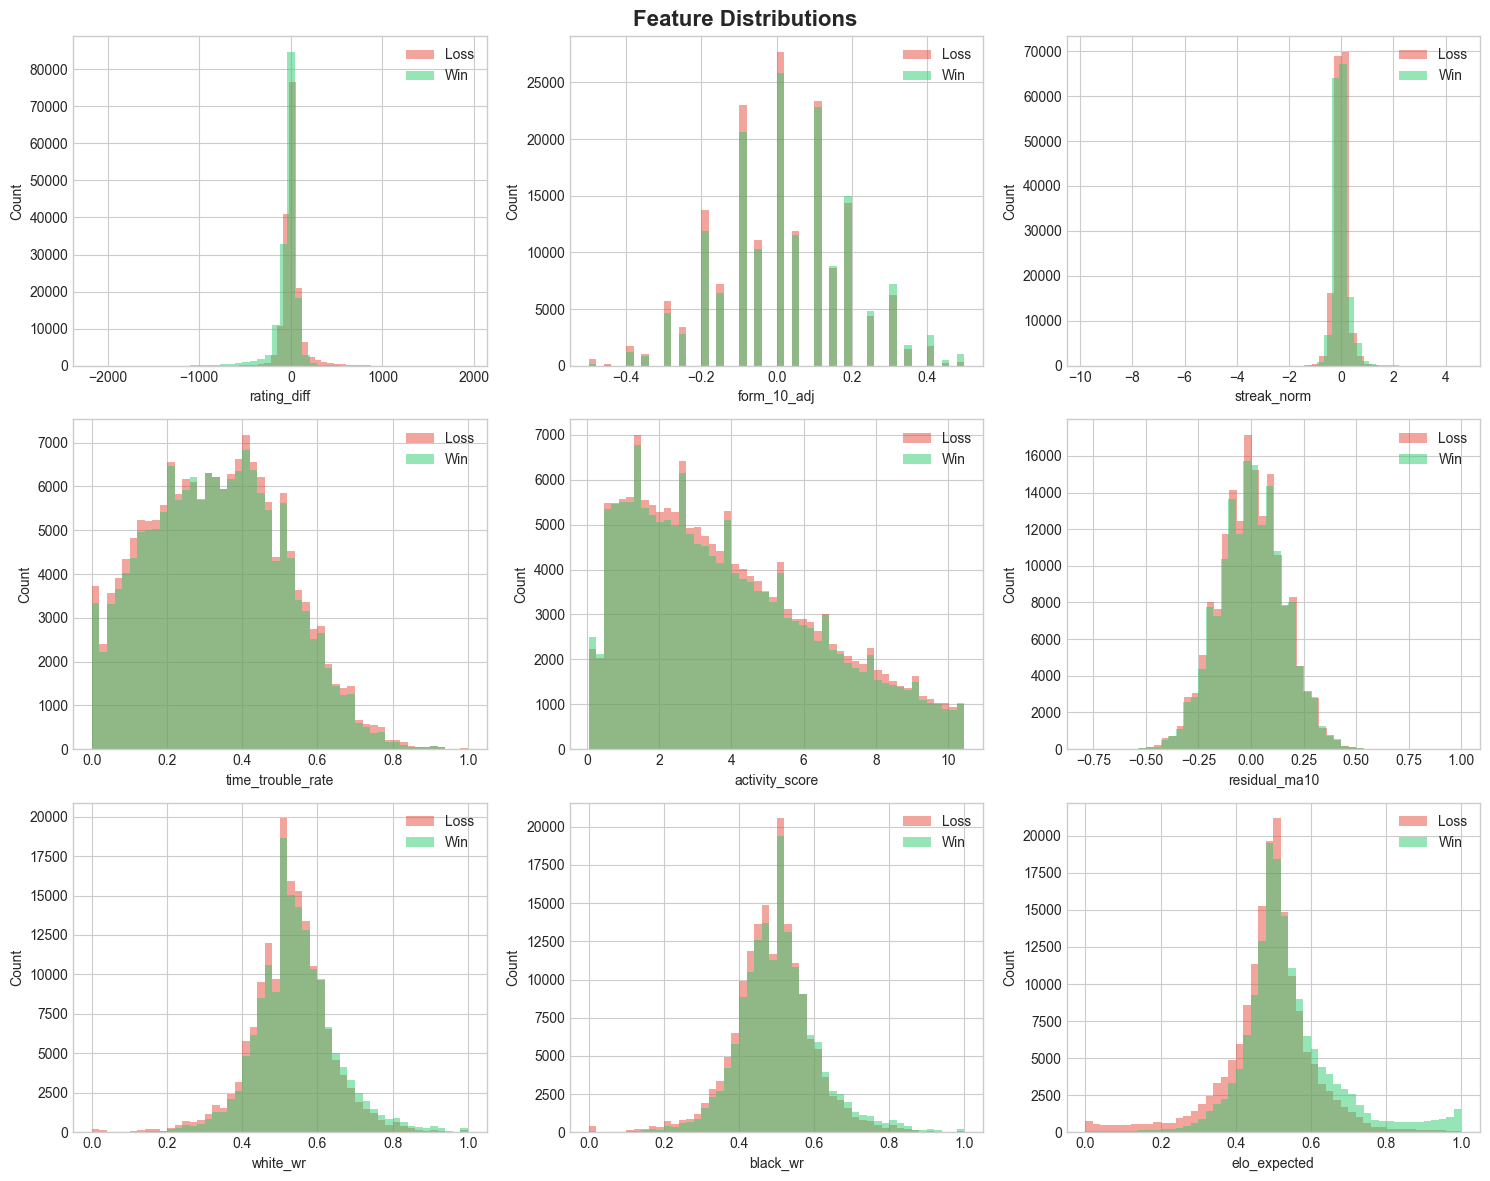

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

plot_features = [
    'rating_diff', 'form_10_adj', 'streak_norm',
    'time_trouble_rate', 'activity_score', 'residual_ma10',
    'white_wr', 'black_wr', 'elo_expected'
]

for idx, feature in enumerate(plot_features):
    ax = axes[idx // 3, idx % 3]
    
    for outcome, color in [(0, COLOR_LOSS), (1, COLOR_WIN)]:
        data = df_train[df_train[target_column] == outcome][feature]
        ax.hist(data, bins=50, alpha=0.5, color=color, 
                label='Loss' if outcome == 0 else 'Win')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout()
plt.show()

In [22]:
correlations = df_train[feature_columns + [target_column]].corr()[target_column].drop(target_column)
correlations = correlations.sort_values(ascending=True)

fig = px.bar(
    x=correlations.values,
    y=correlations.index,
    orientation='h',
    title='Feature Correlation with Win Outcome',
    labels={'x': 'Correlation', 'y': 'Feature'},
    color=correlations.values,
    color_continuous_scale='RdYlGn'
)
fig.update_layout(template=CHART_TEMPLATE, height=500)
fig.show()

### 7. Model Training

In [23]:
X = df_train[feature_columns].values
y = df_train[target_column].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")
print(f"Train win rate: {y_train.mean():.2%}")
print(f"Test win rate: {y_test.mean():.2%}")

Training set: 263,452 samples
Test set: 65,864 samples
Features: 19
Train win rate: 48.94%
Test win rate: 48.94%


In [24]:
# Define models
models = {
    'Logistic Regression': {
        'model': LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=1000,
            C=1.0
        ),
        'needs_scaling': True
    },
    
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'needs_scaling': False
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            min_samples_split=20,
            random_state=RANDOM_STATE
        ),
        'needs_scaling': False
    },
    
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            num_leaves=31,
            min_child_samples=20,
            random_state=RANDOM_STATE,
            verbose=-1,
            force_col_wise=True
        ),
        'needs_scaling': False
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            min_child_weight=20,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False
        ),
        'needs_scaling': False
    },
    
    'Neural Network': {
        'model': MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=RANDOM_STATE
        ),
        'needs_scaling': True
    }
}

print(f"{len(models)} models defined for comparison")

6 models defined for comparison


In [25]:
results = []
trained_models = {}

print("\nTraining and evaluating models...\n")
print("=" * 80)

for name, config in models.items():
    print(f"Training: {name}")
    
    model = config['model']
    needs_scaling = config['needs_scaling']
    
    X_tr = X_train_scaled if needs_scaling else X_train
    X_te = X_test_scaled if needs_scaling else X_test
    
    # Train
    start_time = time.time()
    model.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)
    logloss = log_loss(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='roc_auc')
    
    # Store results
    result = {
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Brier Score': brier,
        'Log Loss': logloss,
        'F1 Score': f1,
        'CV ROC AUC (mean)': cv_scores.mean(),
        'CV ROC AUC (std)': cv_scores.std(),
        'Train Time (s)': train_time
    }
    results.append(result)
    
    trained_models[name] = {
        'model': model,
        'needs_scaling': needs_scaling,
        'predictions': y_pred_proba
    }
    
    print(f"  Accuracy:     {accuracy:.4f}")
    print(f"  ROC AUC:      {roc_auc:.4f}")
    print(f"  Brier Score:  {brier:.4f}")
    print(f"  Log Loss:     {logloss:.4f}")
    print(f"  F1 Score:     {f1:.4f}")
    print(f"  CV AUC:       {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")
    print(f"  Train time:   {train_time:.2f}s")

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('ROC AUC', ascending=False)

print("All models trained!")


Training and evaluating models...

Training: Logistic Regression
  Accuracy:     0.5718
  ROC AUC:      0.6095
  Brier Score:  0.2380
  Log Loss:     0.6674
  F1 Score:     0.5242
  CV AUC:       0.6040 +/- 0.0021
  Train time:   0.22s
Training: Random Forest
  Accuracy:     0.5732
  ROC AUC:      0.6107
  Brier Score:  0.2375
  Log Loss:     0.6660
  F1 Score:     0.5185
  CV AUC:       0.6048 +/- 0.0022
  Train time:   20.78s
Training: Gradient Boosting
  Accuracy:     0.5731
  ROC AUC:      0.6108
  Brier Score:  0.2373
  Log Loss:     0.6655
  F1 Score:     0.5212
  CV AUC:       0.6044 +/- 0.0026
  Train time:   236.07s
Training: LightGBM
  Accuracy:     0.5718
  ROC AUC:      0.6102
  Brier Score:  0.2375
  Log Loss:     0.6657
  F1 Score:     0.5214
  CV AUC:       0.6034 +/- 0.0026
  Train time:   5.56s
Training: XGBoost
  Accuracy:     0.5719
  ROC AUC:      0.6091
  Brier Score:  0.2377
  Log Loss:     0.6661
  F1 Score:     0.5220
  CV AUC:       0.6024 +/- 0.0026
  Train t

### 8. Model Evaluation & Comparison

In [26]:
# Results comparison table
print("\nModel Comparison Results:")
display(df_results.style.format({
    'Accuracy': '{:.4f}',
    'ROC AUC': '{:.4f}',
    'Brier Score': '{:.4f}',
    'Log Loss': '{:.4f}',
    'F1 Score': '{:.4f}',
    'CV ROC AUC (mean)': '{:.4f}',
    'CV ROC AUC (std)': '{:.4f}',
    'Train Time (s)': '{:.2f}'
}).background_gradient(subset=['ROC AUC', 'Accuracy'], cmap='Greens'))


Model Comparison Results:


In [27]:
metrics_to_plot = ['Accuracy', 'ROC AUC', 'F1 Score']

fig = go.Figure()

for metric in metrics_to_plot:
    fig.add_trace(go.Bar(
        name=metric,
        x=df_results['Model'],
        y=df_results[metric],
        text=df_results[metric].round(4),
        textposition='outside'
    ))

fig.update_layout(
    title='Model Performance Comparison',
    barmode='group',
    template=CHART_TEMPLATE,
    height=500,
    yaxis_range=[0.5, 1.0]
)
fig.show()

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    name='Random (AUC=0.5)',
    line=dict(dash='dash', color='gray')
))

colors = px.colors.qualitative.Set1

for idx, (name, data) in enumerate(trained_models.items()):
    y_pred_proba = data['predictions']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'{name} (AUC={auc:.4f})',
        line=dict(color=colors[idx % len(colors)])
    ))

fig.update_layout(
    title='ROC Curves Comparison',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template=CHART_TEMPLATE,
    height=500
)
fig.show()

In [29]:
# Feature Importance for best model
best_model_name = df_results.iloc[0]['Model']
print(f"\nFeature Importance for {best_model_name}:")

if best_model_name in ['LightGBM', 'XGBoost', 'Random Forest', 'Gradient Boosting']:
    model = trained_models[best_model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=True)
        
        fig = px.bar(
            importance_df.tail(15),
            x='Importance',
            y='Feature',
            orientation='h',
            title=f'Feature Importance ({best_model_name})',
            color='Importance',
            color_continuous_scale='Viridis'
        )
        fig.update_layout(template=CHART_TEMPLATE, height=500)
        fig.show()


Feature Importance for Gradient Boosting:


In [38]:
best_model_name = 'LightGBM'  
print(f"\nFeature Importance for {best_model_name}:")

model = trained_models[best_model_name]['model']

importance_split = model.feature_importances_
importance_gain = model.booster_.feature_importance(importance_type='gain')

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Split Count': importance_split,
    'Gain': importance_gain
}).sort_values('Gain', ascending=True)

fig = px.bar(
    importance_df.tail(15),
    x='Gain',
    y='Feature',
    orientation='h',
    title=f'Feature Importance by Gain ({best_model_name})',
    color='Gain',
    color_continuous_scale='Viridis'
)
fig.update_layout(template=CHART_TEMPLATE, height=500)
fig.show()


Feature Importance for LightGBM:


### 9. Save Best Model

In [41]:
best_model_name = 'LightGBM'
best_model_data = trained_models[best_model_name]

lgb_results = df_results[df_results['Model'] == 'LightGBM'].iloc[0]

print(f"Selected Model: {best_model_name}")
print(f"  ROC AUC: {lgb_results['ROC AUC']:.4f}")
print(f"  Accuracy: {lgb_results['Accuracy']:.4f}")
print(f"  Brier Score: {lgb_results['Brier Score']:.4f}")
print(f"  Train Time: {lgb_results['Train Time (s)']:.2f}s")

Selected Model: LightGBM
  ROC AUC: 0.6102
  Accuracy: 0.5718
  Brier Score: 0.2375
  Train Time: 5.56s


In [43]:
lgb_results = df_results[df_results['Model'] == 'LightGBM'].iloc[0]

model_package = {
    'model': calibrated_model,
    'base_model': base_model,
    'model_name': best_model_name,
    'feature_columns': feature_columns,
    'scaler': scaler if needs_scaling else None,
    'needs_scaling': needs_scaling,
    'metrics': {
        'roc_auc': lgb_results['ROC AUC'],
        'accuracy': lgb_results['Accuracy'],
        'brier_score': brier_after,
        'log_loss': lgb_results['Log Loss']
    },
    'training_info': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'game_type': GAME_TYPE,
        'training_date': datetime.now().isoformat()
    }
}

with open(MODEL_OUTPUT_PATH, 'wb') as f:
    pickle.dump(model_package, f)

print(f"Model saved to: {MODEL_OUTPUT_PATH}")
print(f"File size: {os.path.getsize(MODEL_OUTPUT_PATH) / (1024*1024):.2f} MB")

Model saved to: win_probability_model.pkl
File size: 1.00 MB


In [44]:
# Save training data
df_train.to_parquet(DATA_OUTPUT_PATH, index=False)

print(f"Training data saved to: {DATA_OUTPUT_PATH}")
print(f"File size: {os.path.getsize(DATA_OUTPUT_PATH) / (1024*1024):.2f} MB")

Training data saved to: training_data.parquet
File size: 29.06 MB
